In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
from xgboost import XGBRegressor, XGBRFRegressor

In [4]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [5]:
from sklearn.ensemble import VotingRegressor, StackingRegressor, ExtraTreesRegressor

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
train.sample(10)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
17338,45787620,8154,1677,FORD,Transit,2003,Microbus,No,Diesel,2.0 Turbo,190000 km,4,Manual,Front,4-May,Left wheel,Blue,2
670,45787482,941,-,MOSKVICH,2140,1985,Sedan,No,Petrol,1.5,20000000 km,4,Manual,Rear,4-May,Left wheel,Red,0
11915,45453144,19757,-,SKODA,Octavia SCOUT,2011,Universal,No,Petrol,1.8 Turbo,200000 km,4,Manual,4x4,4-May,Left wheel,Silver,12
13445,45789733,16308,-,TOYOTA,Prius,2008,Sedan,Yes,Petrol,1.5,259200 km,4,Automatic,Front,4-May,Left wheel,Green,8
3580,45789837,6899,1090,CHEVROLET,Captiva,2008,Jeep,Yes,Diesel,2,77778 km,4,Automatic,Front,4-May,Left wheel,Silver,4
18054,45798604,3450,-,OPEL,Vectra,1989,Sedan,No,Petrol,2,300000 km,4,Manual,Front,4-May,Left wheel,White,0
11022,30551412,370,-,TOYOTA,Land Cruiser 200,2018,Jeep,Yes,Petrol,4,15000 km,8,Automatic,4x4,4-May,Left wheel,Black,12
12555,45788784,15681,779,VOLKSWAGEN,Passat,2013,Sedan,No,Petrol,2.5,156000 km,4,Tiptronic,Front,4-May,Left wheel,Grey,8
15181,45802818,55230,1079,HYUNDAI,Santa FE,2018,Jeep,Yes,Diesel,2,49396 km,4,Automatic,Front,4-May,Left wheel,White,4
16001,45803367,20382,765,HYUNDAI,Sonata,2015,Sedan,Yes,Petrol,2,36223 km,4,Automatic,Front,4-May,Left wheel,Silver,4


In [12]:
train['Fuel type'].value_counts()

Petrol            10150
Diesel             4036
Hybrid             3578
LPG                 892
CNG                 494
Plug-in Hybrid       86
Hydrogen              1
Name: Fuel type, dtype: int64

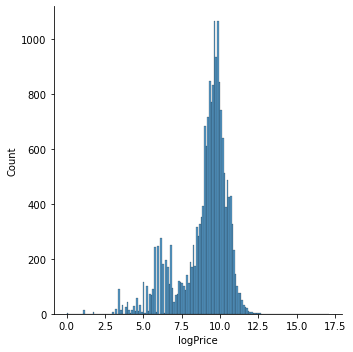

In [9]:
sns.displot(train.logPrice)

In [10]:
lowPrice = np.quantile(train.logPrice, 0.02)
highPrice = np.quantile(train.logPrice, 0.99)
print (lowPrice, highPrice)

4.700480365792417 11.346575677685973


<AxesSubplot:xlabel='cappedLogPrice', ylabel='Count'>

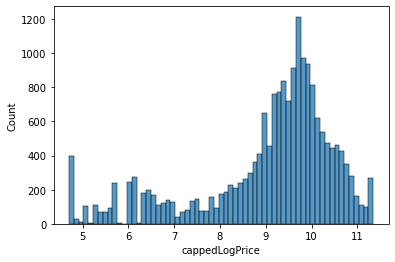

In [11]:
train['cappedLogPrice'] = train.logPrice
train.loc[train.logPrice < lowPrice, 'cappedLogPrice'] = lowPrice
train.loc[train.logPrice > highPrice, 'cappedLogPrice'] = highPrice
sns.histplot(train.cappedLogPrice)

<AxesSubplot:xlabel='cappedLogPrice'>

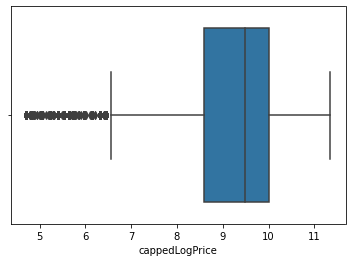

In [12]:
sns.boxplot(train.cappedLogPrice)

In [13]:
df_train = train.drop(columns=['ID', 'Price', 'logPrice'])

In [14]:
df_train.head()

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,cappedLogPrice
0,-,GAZ,20,1953,Sedan,No,Petrol,2,0 km,4,Manual,Rear,4-May,Left wheel,Beige,0,10.854102
1,-,GAZ,20,1953,Jeep,No,Petrol,3.2,100000 km,4,Manual,4x4,2-Mar,Left wheel,Green,0,8.070906
2,-,GAZ,21,1964,Sedan,No,Petrol,2.4,0 km,4,Manual,Rear,4-May,Left wheel,Sky blue,0,8.966994
3,-,GAZ,24,1990,Universal,Yes,Petrol,6.3,2000 km,8,Manual,4x4,2-Mar,Left wheel,Green,0,8.581294
4,-,AUDI,50,2018,Coupe,Yes,Petrol,0.5,4000 km,1,Tiptronic,Rear,>5,Right-hand drive,Blue,0,7.170120


In [15]:
cat_cols = ['Category', 'Leather interior', 'Fuel type',
           'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']
num_cols = ['Levy', 'Prod. year', 'Engine volume', 
            'Airbags', 'Cylinders', 'Mileage']
print (len(df_train.columns.to_list()), 
        len(cat_cols),
        len(num_cols))

17 8 6


In [16]:
sorted(train.Doors.unique())

['2-Mar', '4-May', '>5']

## Mileage

In [17]:
df_train.loc[df_train.Levy=='-', 'Levy'] = 0
df_train.Mileage = train.Mileage.apply(lambda x: int(x[:-3]))
df_train.loc[df_train.Mileage==0, 'Mileage'] = None

In [18]:
df_train['Mileage'] = df_train['Mileage'].\
                        fillna(df_train.groupby('Prod. year')['Mileage'].transform('median'))
df_train.Mileage.fillna(df_train.Mileage.mean(), inplace=True)
up_mileage = np.quantile(df_train.Mileage, 0.99)
df_train.loc[df_train.Mileage > up_mileage, 'Mileage'] = up_mileage

In [19]:
df_train[num_cols].head()

,Levy,Prod. year,Engine volume,Airbags,Cylinders,Mileage
0,0,1953,2,0,4,150000.0
1,0,1953,3.2,0,4,100000.0
2,0,1964,2.4,0,4,50000.0
3,0,1990,6.3,0,8,2000.0
4,0,2018,0.5,0,1,4000.0


In [20]:
df_train.Levy = df_train.Levy.astype(int)

In [21]:
df_train['Engine volume'] = df_train['Engine volume'].apply(lambda x: float(x.split(' ')[0]))
df_train['Engine volume'] = df_train['Engine volume'].astype(float)

In [22]:
df_dummies = pd.get_dummies(df_train[cat_cols], drop_first=True)
df_dummies.tail()

,Category_Coupe,Category_Goods wagon,Category_Hatchback,Category_Jeep,Category_Limousine,Category_Microbus,Category_Minivan,Category_Pickup,Category_Sedan,Category_Universal,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
19232,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19233,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
19234,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19235,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19236,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Feature Engineering

<AxesSubplot:xlabel='Prod. year'>

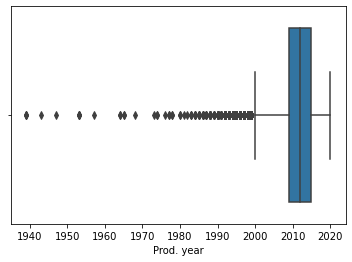

In [23]:
sns.boxplot(df_train['Prod. year'])

In [24]:
df_train['KMPerYear'] = np.log(df_train.Mileage / (2021 - df_train['Prod. year']))
if not 'KMPerYear' in num_cols:
    num_cols.append('KMPerYear')        

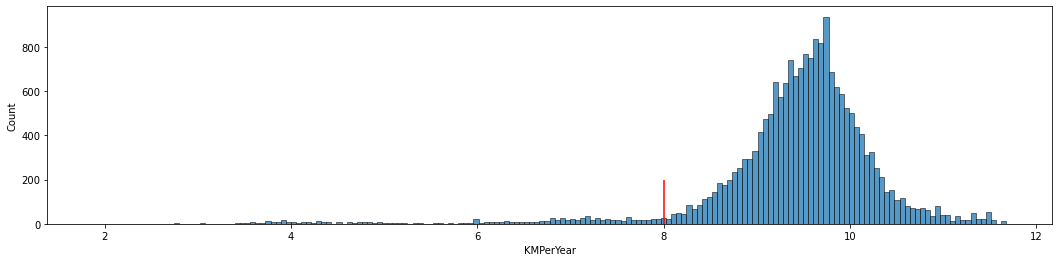

In [25]:
plt.figure(figsize=(18, 4))
sns.histplot(df_train.KMPerYear)
plt.vlines(8, ymin=0, ymax=200, colors='r')

In [26]:
df_train['Rare'] = ((df_train['Prod. year']<2000) & (df_train.KMPerYear<8) | (df_train.KMPerYear>12.5))
if not ('Rare' in num_cols):
    num_cols.append('Rare')

In [27]:
df_train.Rare.value_counts()

False    19036
True       201
Name: Rare, dtype: int64

In [28]:
df_train['isTurbo'] = train['Engine volume'].apply(lambda x: x.split(' ')[-1]=='Turbo')
if not 'isTurbo' in num_cols:
    num_cols.append('isTurbo')

In [29]:
df_train[num_cols].sample(5)

,Levy,Prod. year,Engine volume,Airbags,Cylinders,Mileage,KMPerYear,Rare,isTurbo
5703,0,2014,3.5,12,6,42774.0,8.717776,False,False
11354,891,2016,2.0,10,4,120000.0,10.085809,False,False
1624,503,2012,1.5,4,4,33395.0,8.218937,False,False
17332,0,2007,2.5,2,4,200000.0,9.567015,False,True
4284,749,2014,2.4,4,4,32769.0,8.451328,False,False


<AxesSubplot:xlabel='ft1', ylabel='Count'>

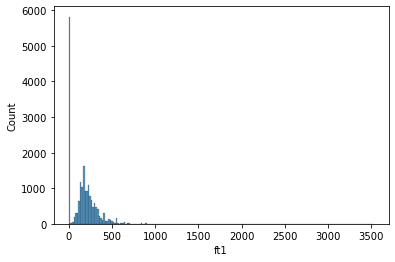

In [30]:
df_train['ft1'] = np.sqrt(df_train.Levy) * (2021 - df_train['Prod. year'])
if not 'ft1' in num_cols:
    num_cols.append('ft1')
sns.histplot(df_train.ft1)

<AxesSubplot:xlabel='ft3', ylabel='Count'>

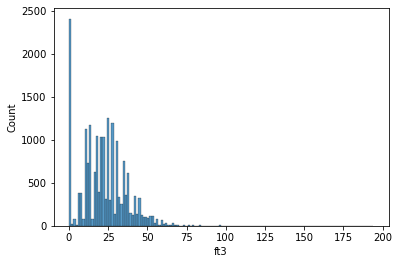

In [31]:
df_train['ft3'] = np.sqrt(df_train['Airbags']) * (2021 - df_train['Prod. year'])
if not 'ft3' in num_cols:
    num_cols.append('ft3')
sns.histplot(df_train.ft3)

# Base N Encoding

In [32]:
import category_encoders as ce

### Manufacturer

In [33]:
manf_encoder = ce.BaseNEncoder(cols=['Manufacturer'], return_df = True, base=4)
manf_encoder.fit(df_train[['Manufacturer']])
manf_df = manf_encoder.transform((df_train[['Manufacturer']]))
manf_df.sample(5)

,Manufacturer_0,Manufacturer_1,Manufacturer_2,Manufacturer_3,Manufacturer_4
3535,0,0,1,0,0
1832,0,0,1,3,0
3157,0,0,1,1,2
4091,0,0,0,1,1
9405,0,0,1,2,1


### Model Name

In [34]:
df_train['ModelName'] = df_train.Model.apply(lambda x: x.split(' ')[0])
df_train.loc[df_train.ModelName.apply(lambda x : x.isnumeric()), 'ModelName'] = 'Others'
df_train.loc[df_train.ModelName.apply(lambda x : '+' in x), 'ModelName'] = 'Others'

In [35]:
name_encoder = ce.BaseNEncoder(cols=['ModelName'], return_df = True, base=6)
name_encoder.fit(df_train[['ModelName']])
model_df = name_encoder.transform((df_train[['ModelName']]))
model_df.sample(5)

,ModelName_0,ModelName_1,ModelName_2,ModelName_3,ModelName_4
18570,0,2,2,0,3
18885,0,2,2,1,0
11454,0,1,2,3,2
12449,0,1,3,2,5
7705,0,0,4,4,4


# Modelling

In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = pd.concat([df_train[num_cols], df_dummies, model_df, manf_df], axis=1)
y = df_train.cappedLogPrice
X_cols = X.columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X[X_cols], y, 
                                                    test_size = 0.2, random_state = 42,
                                                    stratify = df_train.Airbags)
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_cols)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_cols)
X_train.head()

,Levy,Prod. year,Engine volume,Airbags,Cylinders,Mileage,KMPerYear,Rare,isTurbo,ft1,...,ModelName_0,ModelName_1,ModelName_2,ModelName_3,ModelName_4,Manufacturer_0,Manufacturer_1,Manufacturer_2,Manufacturer_3,Manufacturer_4
16814,753,2012,2.4,12,4,152466.0,9.737472,False,False,246.967609,...,0,2,0,0,5,0,0,1,3,3
17495,0,2004,1.8,2,4,223000.0,9.481714,False,False,0.000000,...,0,2,0,5,5,0,0,2,0,3
4310,891,2016,2.0,12,4,59408.0,9.382746,False,False,149.248116,...,0,0,2,5,4,0,0,2,2,2
1935,1518,2003,1.8,4,4,23450.0,7.172254,False,False,701.307351,...,0,0,0,5,4,0,0,1,3,0
15285,1079,2018,2.0,4,4,69000.0,10.043249,False,False,98.544406,...,0,1,5,1,5,0,0,1,2,1


# Random Forest

In [37]:
rf_best = RandomForestRegressor(bootstrap=False, max_depth=80, max_features='sqrt', random_state=42,
                      min_samples_split=5, n_estimators=133).fit(X_train_scaled, y_train)
print (rf_best.score(X_train_scaled, y_train), rf_best.score(X_test_scaled, y_test))

0.9552372740830406 0.72636056546864


In [38]:
rf_prod = RandomForestRegressor(bootstrap=False, max_depth=80, max_features='sqrt', random_state=42,
                      min_samples_split=5, n_estimators=133).fit(X[X_cols], y)

In [39]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(
        np.exp(y_test), 
        np.exp(rf_best.predict(X_test_scaled))))

0.7954860910278782

In [40]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(
        np.exp(y_train), 
        np.exp(rf_best.predict(X_train_scaled))))

0.320359180471976

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

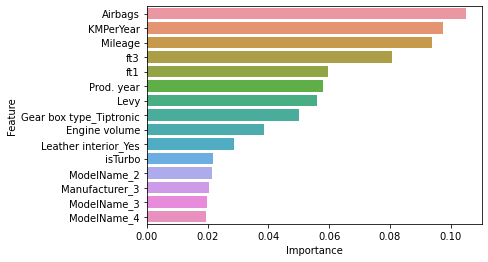

In [41]:
df_importance = pd.DataFrame(rf_best.feature_importances_, columns = ['Importance'])
df_importance['Feature'] = X_cols
df_importance = df_importance[['Feature', 'Importance']].sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=df_importance.head(15))

---


# Ensemble - Stack Regression and Voting

In [42]:
ens_rf = RandomForestRegressor(bootstrap=False, max_depth=80, max_features='sqrt', random_state=42,
                      min_samples_split=5, n_estimators=133)
ens_xg = XGBRegressor(subsample= 0.5, objective= 'reg:squarederror', n_estimators= 500, min_child_weight= 1,
                      max_depth= 10, learning_rate= 0.1, colsample_bytree= 0.5)
ens_ext = ExtraTreesRegressor(max_depth=80, max_features='sqrt', random_state=42,
                      min_samples_split=5, n_estimators=133)

vot_model = VotingRegressor([('rf', ens_rf), ('xg', ens_xg), ('ext', ens_ext)])
vot_model.fit(X_train_scaled, y_train)
vot_model.score(X_test_scaled, y_test)

0.7243373444478891

In [44]:
np.sqrt(mean_squared_log_error(
        np.exp(y_test), 
        np.exp(vot_model.predict(X_test_scaled))))

0.798430273162303

---

In [75]:
df_test = test.drop(columns = 'ID')

df_test.loc[df_test.Levy=='-', 'Levy'] = 0
df_test.loc[df_test.Doors=='04-May', 'Doors'] = '4-May'
df_test.loc[df_test.Doors=='02-Mar', 'Doors'] = '2-Mar'

df_test.Mileage = df_test.Mileage.apply(lambda x: int(x[:-3]))
df_test.loc[df_test.Mileage==0, 'Mileage'] = None
df_test['Mileage'] = df_test['Mileage'].\
                        fillna(df_test.groupby('Prod. year')['Mileage'].transform('median'))
df_test.Mileage.fillna(df_test.Mileage.mean(), inplace=True)

df_test['Engine volume'].apply(lambda x: float(x.split(' ')[0]))
df_test['Engine volume'] = df_test['Engine volume'].apply(lambda x: float(x.split(' ')[0]))

df_test.Levy = df_test.Levy.astype(int)
df_test.loc[df_test.Cylinders > 15, 'Cylinders'] = 15

df_dummies_test = pd.get_dummies(df_test[cat_cols], drop_first=True)

df_test['KMPerYear'] = np.log((df_test.Mileage) / (2021 - df_test['Prod. year']))

df_test['Rare'] = ((df_test['Prod. year']<2000) & (df_test.KMPerYear<8) | (df_test.KMPerYear>12.5))
df_test['isTurbo'] = test['Engine volume'].apply(lambda x: x.split(' ')[-1]=='Turbo')

df_test['ft1'] = np.sqrt(df_test.Levy) * (2021 - df_test['Prod. year'])
df_test['ft3'] = np.sqrt(df_test['Airbags']) * (2021 - df_test['Prod. year'])

df_test['ModelName'] = df_test.Model.apply(lambda x: x.split(' ')[0])
df_test.loc[df_test.ModelName.apply(lambda x : x.isnumeric()), 'ModelName'] = 'Others'
df_test.loc[df_test.ModelName.apply(lambda x : '+' in x), 'ModelName'] = 'Others'

model_df_test = name_encoder.transform(df_test['ModelName'])
manf_df_test = manf_encoder.transform(df_test['Manufacturer'])

#############################################

X_submit = pd.concat([df_test[num_cols], df_dummies_test, model_df_test, manf_df_test], axis=1)
X_submit_scaled = pd.DataFrame(scaler.transform(X_submit), columns=X_cols)
X_submit_scaled.head()

,Levy,Prod. year,Engine volume,Airbags,Cylinders,Mileage,KMPerYear,Rare,isTurbo,ft1,...,ModelName_0,ModelName_1,ModelName_2,ModelName_3,ModelName_4,Manufacturer_0,Manufacturer_1,Manufacturer_2,Manufacturer_3,Manufacturer_4
0,-1.111501,0.195164,-0.349990,0.791105,-0.483287,-0.019847,0.281132,-0.105689,2.995568,-1.040142,...,0.0,-0.952072,1.538404,1.125706,-1.478144,0.0,-0.008061,0.057415,-0.261412,-1.468745
1,-1.111501,0.195164,0.110933,0.791105,-0.483287,-1.219124,-1.583440,-0.105689,-0.333826,-1.040142,...,0.0,0.482234,1.538404,1.125706,1.445054,0.0,-0.008061,0.057415,0.780243,-0.446700
2,-1.111501,-1.026999,-0.926144,0.328159,-0.483287,0.224074,-0.177695,-0.105689,-0.333826,-1.040142,...,0.0,1.916541,-1.331163,0.622028,0.275775,0.0,-0.008061,0.057415,-1.303068,1.597389
3,0.600847,0.195164,1.032778,1.254051,1.190838,-0.030010,0.273541,-0.105689,-0.333826,0.734690,...,0.0,1.916541,-0.183336,-0.889005,-0.308865,0.0,-0.008061,-1.560818,1.821899,0.575344
4,-1.111501,-3.122136,-0.810913,-1.523624,-0.483287,0.549302,-0.597361,-0.105689,-0.333826,-1.040142,...,0.0,-0.952072,-1.331163,1.125706,0.860415,0.0,-0.008061,0.057415,1.821899,-1.468745


In [76]:
y_submit = pd.DataFrame(np.round(np.exp(rf_prod.predict(X_submit_scaled)), 2) , columns=['Price'])
y_submit.to_csv('submission.csv', index=False)

In [156]:
#y_submit = pd.DataFrame(np.round(np.exp(vot_model.predict(X_submit_scaled)), 2) , columns=['Price'])
#y_submit.to_csv('submission.csv', index=False)

<AxesSubplot:xlabel='Airbags'>

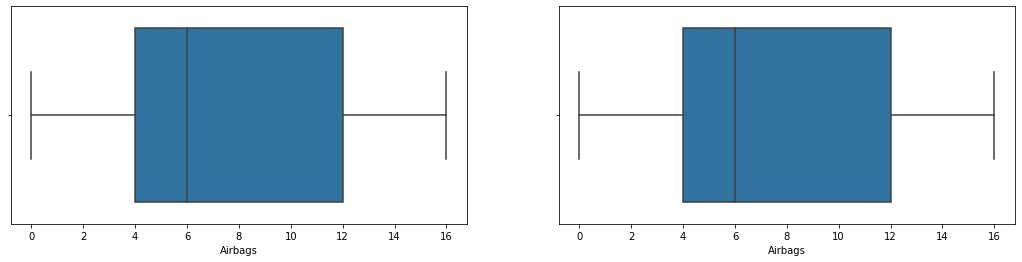

In [118]:
plt.figure(figsize=(18, 4))

plt.subplot(121); sns.boxplot(df_train.Airbags)
plt.subplot(122); sns.boxplot(df_test.Airbags)
